In [1]:
import torch
from torch import nn

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

In [4]:
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
y = digits.target

# numpy의 ndarray를 파이토치의 tensor로 변환
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.int64)

# softmax cross entropy
loss_fn = nn.CrossEntropyLoss()

# Adam
optimizer = optim.Adam(net.parameters())

# 손실 함수의 로그
losses = []

# 100회 반복
for epoc in range(100):
    # backward 메서드로 계산된 이전 값을 삭제
    optimizer.zero_grad()
    
    # 선형 모델로 y의 예측 값 계산
    y_pred = net(X)
    
    # MSE loss 와 w를 사용한 미분 계산
    loss = loss_fn(y_pred, y)
    loss.backward()
    
    # 경사를 갱신
    optimizer.step()
    
    # 수렴 확인을 위해 loss를 기록해 둔다
    losses.append(loss.item())

In [5]:
# torch.max는 집계축을 지정하면 최댓값 뿐만 아니라 그 위치도 반환한다
_, y_pred = torch.max(net(X), 1)
# 정답률을 계산한다
(y_pred == y).sum().item() / len(y)

0.9504730105731776

TensorDataset을 DataLoader에 전달해서 데이터의 일부만 간단히 추출하는 예

In [7]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader

# Dataset 작성
ds = TensorDataset(X, y)

# 순서를 섞어서 64개씩 데이터를 반환하는 DataLoader 작성
loader = DataLoader(ds, batch_size=64, shuffle=True)

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# 최적화 실행
losses = []
for epoch in range(10):
    running_loss = 0.0
    for xx, yy in loader:
        # xx, yy는 64개만 받는다
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss)

In [8]:
import torch
from torch import nn, optim

# 데이터를 훈련용, 검증용으로 분할
from sklearn.model_selection import train_test_split

# 전체의 30%는 검증용
X = digits.data
Y = digits.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train, dtype=torch.int64)
X_test = torch.tensor(X_test, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.int64)

# 여러 층을 쌓아서 깊은 신경망을 구축한다.
k = 100
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, 10)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())
# 훈련용 데이터로 DataLoader를 작성
ds = TensorDataset(X_train, Y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

In [10]:
train_losses = []
test_losses = []
for epoch in range(100):
    running_loss = 0.0
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, Y_test)
    test_losses.append(test_loss.item())

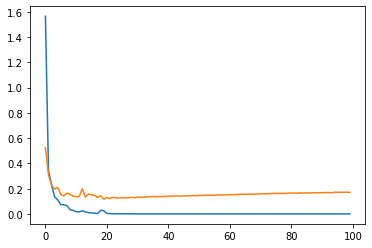

In [13]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.plot(train_losses)
plt.plot(test_losses)

In [14]:
# 확률 0.5로 랜덤으로 변수의 차원을 버리는 Dropout을 각 층에 추가
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, 10)
)

In [15]:
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []
for epoch in range(100):
    running_loss = 0.0
    # 신경망을 훈련 모드로 설정
    net.train()
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    
    # 신경망을 평가 모드로 설정하고 검증 데이터의 손실 함수를 계산
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, Y_test)
    test_losses.append(test_loss.item())

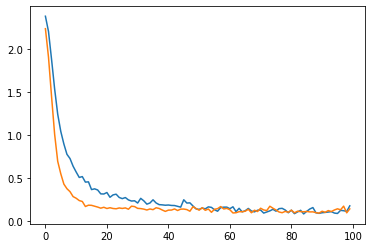

In [18]:
plt.plot(train_losses)
plt.plot(test_losses)

In [19]:
# Linear 층에는 BatchNorm1d를 적용한다
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, 10)
)

In [20]:
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []
for epoch in range(100):
    running_loss = 0.0
    # 신경망을 훈련 모드로 설정
    net.train()
    for i, (xx, yy) in enumerate(loader):
        y_pred = net(xx)
        loss = loss_fn(y_pred, yy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / i)
    
    # 신경망을 평가 모드로 설정하고 검증 데이터의 손실 함수를 계산
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, Y_test)
    test_losses.append(test_loss.item())

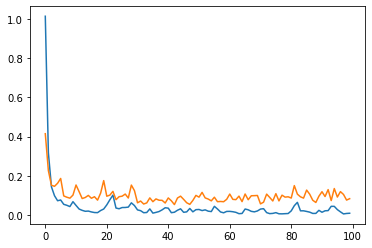

In [22]:
plt.plot(train_losses)
plt.plot(test_losses)

In [24]:
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True, p=0.5):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu()
        x = self.drop(x)
        return x

mlp = nn.Sequential(
    CustomLinear(64, 200),
    CustomLinear(200, 200),
    CustomLinear(200, 200),
    nn.Linear(200, 10)
)

In [25]:
class MyMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.ln1 = CustomLinear(in_features, 200)
        self.ln2 = CustomLinear(200, 200)
        self.ln3 = CustomLinear(200, 200)
        self.ln4 = CustomLinear(200, out_features)
    
    def forward(self, x):
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.ln3(x)
        x = self.ln4(x)
        return x
        
mlp = MyMLP(64, 10)